In [1]:
from src.scripts.hydrate_db import create_db_connection
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import numpy as np
import emoji


SQL_PATH = os.path.join(os.path.abspath(""), "sql")

con = create_db_connection()

In [2]:
SQL_PATH

'C:\\Users\\tthompson2\\Documents\\REPOS\\FFPlayground\\src\\sql'

# MATCHUP LUCK
## Lucky Wins and Unlucky Losses

Extremely lucky win = You won while being the second-lowest scorer in the league. The only person with a lower score was your opponent.
Lucky win = You won while being the third-lowest scorer in the league.

Extremely unlucky loss = You lost while being the second-highest scorer in the league. The only person with a higher score was your opponent.
Unlucky loss = You lost while being the third-highest scorer in the league.

`LuckScore = (NumExtremelyLuckyWins * 2) + NumLuckyWins - (NumExtremelyUnluckyLosses * 2) - NumUnluckyLosses`


In [3]:
## UNLUCKY DFS ##
with open(os.path.join(SQL_PATH, "analytics", "num_extremely_unlucky_losses.sql"), "r") as f:
    query = f.read()
    
extremely_unlucky_losses_df = pd.read_sql(query, con=con)

with open(os.path.join(SQL_PATH, "analytics", "num_unlucky_losses.sql"), "r") as f:
    query = f.read()
    
unlucky_losses_df = pd.read_sql(query, con=con)


In [4]:
## LUCKY DFS ##
with open(os.path.join(SQL_PATH, "analytics", "num_extremely_lucky_wins.sql"), "r") as f:
    query = f.read()
    
extremely_lucky_wins_df = pd.read_sql(query, con=con)

with open(os.path.join(SQL_PATH, "analytics", "num_lucky_wins.sql"), "r") as f:
    query = f.read()
    
lucky_wins_df = pd.read_sql(query, con=con)


In [5]:
## MERGE, CALC, SORT ##
luck_df = lucky_wins_df.merge(right=extremely_lucky_wins_df, how="outer", on="RealName").merge(
    right=unlucky_losses_df, how="outer", on="RealName"
).merge(
    right=extremely_unlucky_losses_df, how="outer", on="RealName"
).fillna(0)
luck_df["LuckScore"] = luck_df["NumLuckyWins"] + luck_df["NumExtremelyLuckyWins"] * 2 - luck_df["NumUnluckyLosses"] - (luck_df["NumExtremelyUnluckyLosses"] * 2)
luck_df["BarColor"] = luck_df["LuckScore"].apply(lambda x: (abs(x/10), 0, 0) if x <=0 else (0, x/10, 0))
luck_df = luck_df.sort_values(by="LuckScore", ascending=False)

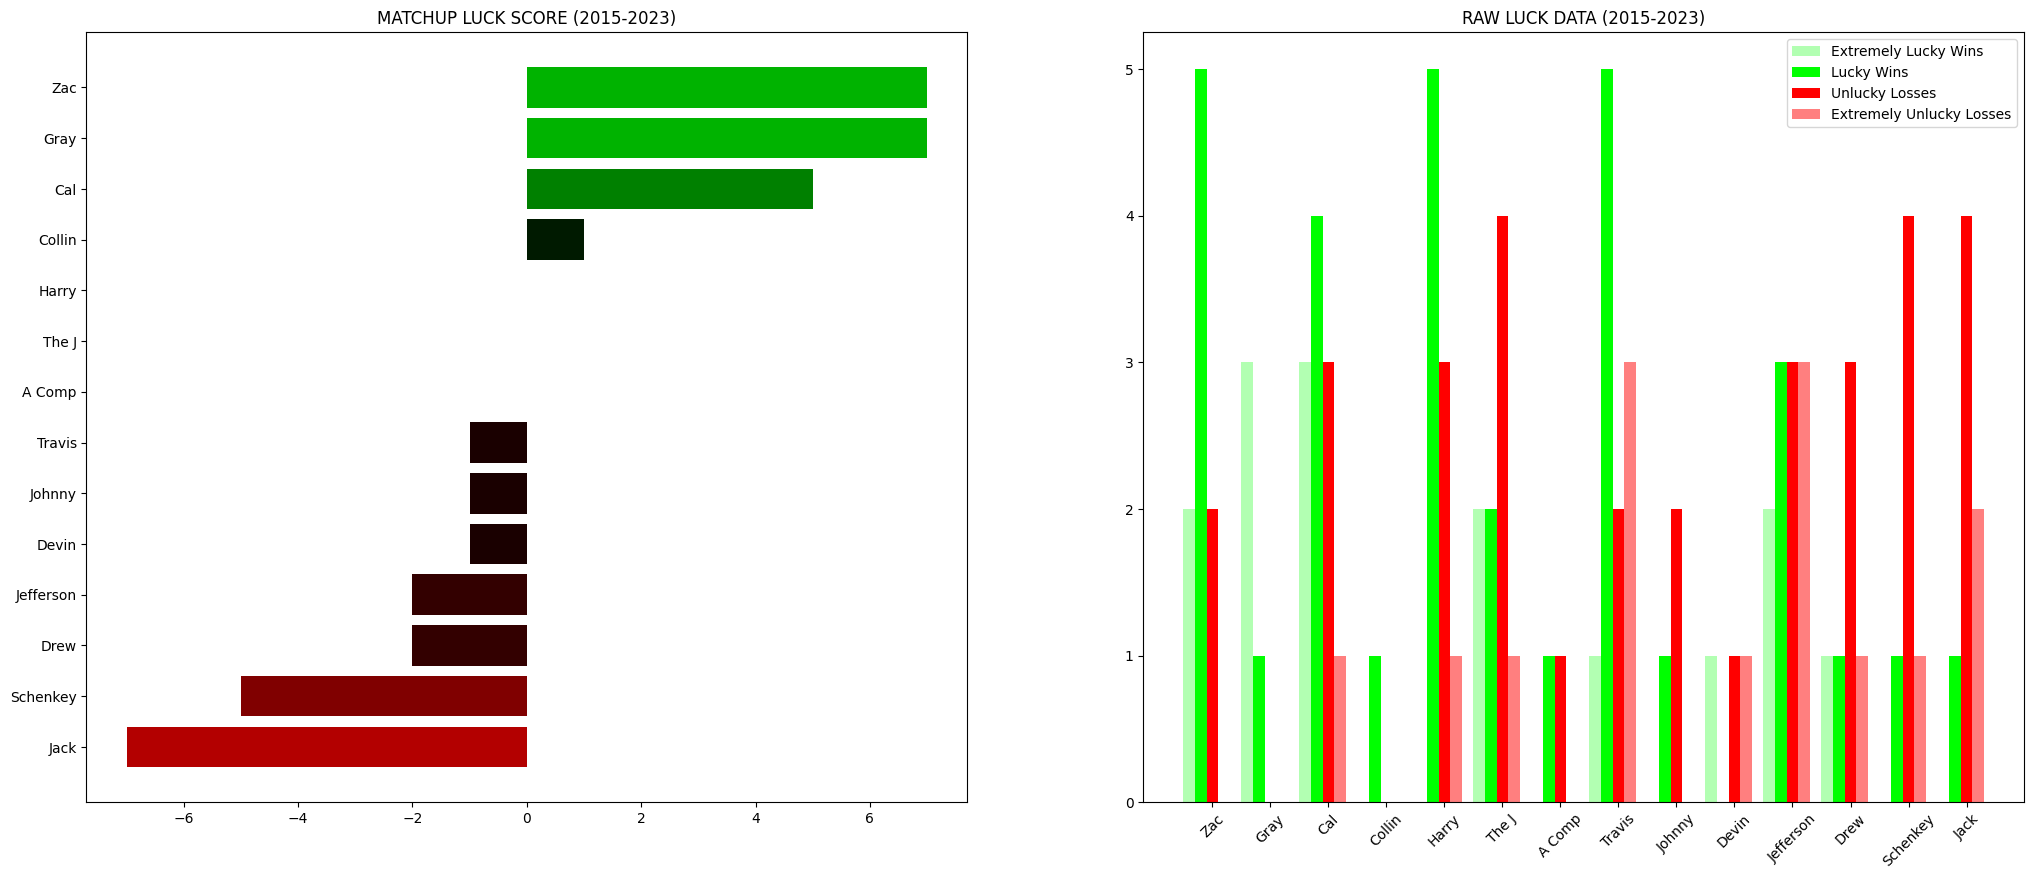

In [6]:
## PLOT ##

fig, (ax1, ax2) = plt.subplots(1, 2)
player_range = np.arange(len(luck_df))

## luck score ##
ax1.barh(player_range, luck_df["LuckScore"], align="center", color=luck_df["BarColor"])
ax1.set_yticks(player_range, labels=luck_df["RealName"])
ax1.invert_yaxis()
ax1.set_title("MATCHUP LUCK SCORE (2015-2023)")
# ax1.set_figwidth(19)

## raw data ##
labels = list(luck_df["RealName"])
width = 0.2
ax2.set_title("RAW LUCK DATA (2015-2023)")
ax2.bar(player_range -  (width * 2), luck_df["NumExtremelyLuckyWins"], width, label="Extremely Lucky Wins", color=(0, 1, 0, 0.3))
ax2.bar(player_range - width, luck_df["NumLuckyWins"], width,  label="Lucky Wins", color=(0, 1, 0, 1))
ax2.bar(player_range, luck_df["NumUnluckyLosses"], width, label="Unlucky Losses", color=(1, 0, 0,  1))
ax2.bar(player_range + width, luck_df["NumExtremelyUnluckyLosses"], width, label="Extremely Unlucky Losses", color=(1, 0, 0,  0.5))

ax2.set_xticks(player_range, labels=luck_df["RealName"])
ax2.set_xticklabels(labels)
ax2.legend()
fig.set_figwidth(25)
fig.set_figheight(10)
plt.xticks(rotation=45)
plt.show()


Based on the formula I came up with, we can empirically determine that Jack has had the worst matchup luck of all of us over the history of our league, while Zac and Gray have had the best luck. The fact that Zac is the luck stat leader seems extremely fitting.

# CUMULATIVE PODIUM STATS
## Calculating an overall league score based on your cumulative podium finishes

`OverallScore = (3 * NumFirstPlaceFinishes) + (2 * NumSecondPlaceFinishes) + NumThirdPlaceFinishes`

In [7]:
## SELECT PODIUM BY YEAR ##
with open(os.path.join(SQL_PATH, "analytics", "select_podium_by_year.sql"), "r") as f:
    query = f.read()
    
podium = pd.read_sql(query, con=con)

In [8]:
all_player_names = pd.read_sql("SELECT DISTINCT RealName FROM leaguemembers", con=con)["RealName"].to_list()

cumulative_podium_df = pd.DataFrame(
    {
        "RealName": n,
        "FirstPlaceFinishes": [f'{emoji.emojize(":1st_place_medal:")} {y}' for y in list(podium[(podium["RealName"] == n) & (podium["FinalRank"] == 1)]["Year"])],
        "SecondPlaceFinishes": [f'{emoji.emojize(":2nd_place_medal:")} {y}' for y in list(podium[(podium["RealName"] == n) & (podium["FinalRank"] == 2)]["Year"])],
        "ThirdPlaceFinishes": [f'{emoji.emojize(":3rd_place_medal:")} {y}' for y in list(podium[(podium["RealName"] == n) & (podium["FinalRank"] == 3)]["Year"])]
    }
    for n in all_player_names
)
cumulative_podium_df["OverallScore"] = (
        3 * cumulative_podium_df["FirstPlaceFinishes"].str.len()
        + 2 * cumulative_podium_df["SecondPlaceFinishes"].str.len()
        + cumulative_podium_df["ThirdPlaceFinishes"].str.len()
)   
cumulative_podium_df["Rank"] = cumulative_podium_df["OverallScore"].rank(method="min", ascending=False).astype(int)
cumulative_podium_df = cumulative_podium_df.sort_values(by="OverallScore", ascending=False).reset_index(drop=True)[["Rank", "RealName", "OverallScore", "FirstPlaceFinishes", "SecondPlaceFinishes", "ThirdPlaceFinishes"]]
cumulative_podium_df

,Rank,RealName,OverallScore,FirstPlaceFinishes,SecondPlaceFinishes,ThirdPlaceFinishes
0,1,Harry,9,[],"[🥈 2015, 🥈 2017, 🥈 2019, 🥈 2020]",[🥉 2018]
1,1,Jack,9,"[🥇 2020, 🥇 2022]",[],"[🥉 2016, 🥉 2019, 🥉 2023]"
2,3,Jefferson,7,[🥇 2023],[🥈 2022],"[🥉 2017, 🥉 2021]"
3,4,The J,6,[🥇 2017],[🥈 2023],[🥉 2020]
4,4,Schenkey,6,[🥇 2015],[🥈 2016],[🥉 2022]
5,6,Drew,5,[🥇 2018],[🥈 2021],[]
6,7,Travis,3,[🥇 2019],[],[]
7,7,Devin,3,[🥇 2016],[],[]
8,7,Gray,3,[🥇 2021],[],[]
9,10,Cal,2,[],[🥈 2018],[]


Here we can see that poor Sharpage has smelled victory 4(!) times but never tasted its sweet nectar. Also interesting to note that while Jack has had the worst historical matchup luck, he is still tied for first in overall league score. 

# Are you an over or underperformer?
## Looking at lifetime W/L records against your lifetime PointsFor:PointsAgainst ratio



In [9]:
with open(os.path.join(SQL_PATH, "analytics", "lifetime_pfa_vs_winpct.sql"), "r") as f:
    query = f.read()
    
df = pd.read_sql(sql=query, con=con)

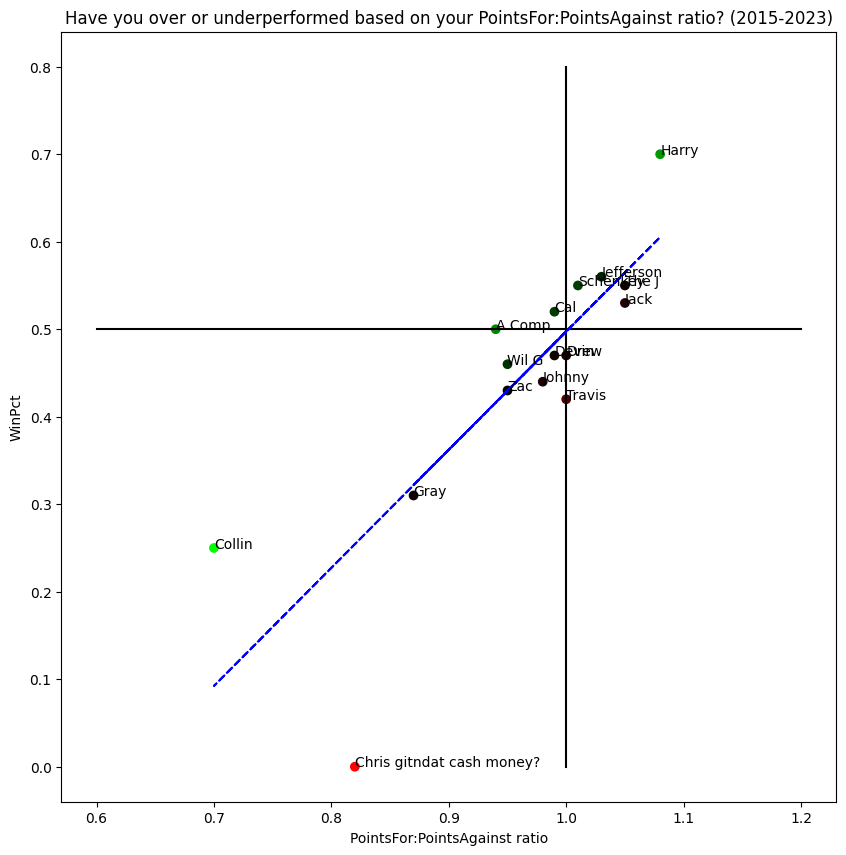

In [10]:
def get_colors(df):
    df["diffs"] = df["WinPct"] - df["ExpectedWinPct"]
    max_success = df["diffs"].max()
    max_fail = df["diffs"].min()
    df["Color"] = df.apply(lambda x: (0, x["diffs"] / max_success, 0) if x["diffs"] > 0 else (x["diffs"] / max_fail, 0, 0), axis=1)
    return df

z = np.polyfit(df["Ratio"], df["WinPct"], 1)
p = np.poly1d(z)
df["ExpectedWinPct"] = p(df["Ratio"]) 
df = get_colors(df)

fig, ax = plt.subplots()
x_spot = 1
y_spot = 0.5
ax.scatter(x=df["Ratio"], y=df["WinPct"], color=df["Color"])
line = mlines.Line2D([x_spot, x_spot], [0,0.8], color="black")
line2 = mlines.Line2D([0.6, 1.2], [y_spot, y_spot], color="black")
ax.add_line(line)
ax.add_line(line2)

ax.plot(df["Ratio"], df["ExpectedWinPct"], "b--")
ax.set_xlabel("PointsFor:PointsAgainst ratio")
ax.set_ylabel("WinPct")
fig.set_figwidth(10)
fig.set_figheight(10)
ax.set_title("Have you over or underperformed based on your PointsFor:PointsAgainst ratio? (2015-2023)")
for i, name in enumerate(df["RealName"]):
    ax.annotate(name, (df.loc[i, "Ratio"], df.loc[i, "WinPct"]))
plt.show()

Here we can see that Harry and Collin, and to a lesser extent Acomp, have severely overperformed based on their points ratio, while (if you take Chris gitndat cashmoney out of the equation) I have severely underperformed based on my 1:1 points ratio. Everyone else is more or less within 1 standard deviation from the norm. Again, it's interesting to note that this is another stat where Jack lands in the "unlucky" realm, and yet he's still tied for first in the overall champion category.

# Who's the best at starting players?
## Examining overall starter performance vs. bench performance

In [12]:
with open(os.path.join(SQL_PATH, "analytics", "lifetime_starters_vs_bench_points.sql"), "r") as f:
    query = f.read()
    
starters_bench_df = pd.read_sql(query, con=con)
starters_bench_df = starters_bench_df.assign(Ratio=(starters_bench_df["StarterPoints"] / starters_bench_df["BenchPoints"])).sort_values(by="Ratio", ascending=False).reset_index(drop=True)
starters_bench_df

,RealName,StarterPoints,BenchPoints,Ratio
0,Travis,11772.74,3896.20,3.021595
1,Drew,12106.76,4053.48,2.986757
2,Jack,13034.86,4429.24,2.942911
3,Gray,10984.34,3749.00,2.929939
4,Cal,12173.74,4177.06,2.914428
5,Jefferson,12730.64,4750.50,2.679853
6,Harry,12675.94,4816.50,2.631774
7,The J,12516.76,4767.38,2.625501
8,Schenkey,12306.30,4709.44,2.613113
9,Zac,10947.36,4346.54,2.518638


Don't shoot the messenger, but it looks like ya boy is the best lineup setter. Just ignore the fact that both my starter and bench point totals are near the bottom. It's not what ya got, it's how ya use it.